## Lab13 

In [1]:
import numpy as np
import random
#import spacy
import tensorflow as tf
from sklearn import preprocessing

C:\Users\stat_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#nlp = spacy.load('en_core_web_md')

#word_apple = nlp('apple')
#word_banana = nlp('banana')
#word_mac = nlp('mac')
#print('%s vs %s: %.6f'%(word_apple, word_banana, word_apple.similarity(word_banana)))

## Processed Data

In [2]:
def get_id2line():
    lines=open('dataset/chatbot/movie_lines.txt', 'r', encoding='utf-8', errors='ignore').read().split('\n')
    id2line = {}
    for line in lines:
        _line = line.split(' +++$+++ ')
        if len(_line) == 5:
            id2line[_line[0]] = _line[4]
    return id2line

'''
    1. Read from 'movie_conversations.txt'
    2. Create a list of [list of line_id's]
'''
def get_conversations():
    conv_lines = open('dataset/chatbot/movie_conversations.txt').read().split('\n')
    convs = [ ]
    for line in conv_lines[:-1]:
        _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
        convs.append(_line.split(','))
    return convs

'''
    1. Get each conversation
    2. Get each line from conversation
    3. Save each conversation to file
'''
def extract_conversations(convs,id2line,path=''):
    idx = 0
    for conv in convs:
        f_conv = open(path + str(idx)+'.txt', 'w')
        for line_id in conv:
            f_conv.write(id2line[line_id])
            f_conv.write('\n')
        f_conv.close()
        idx += 1

'''
    Get lists of all conversations as Questions and Answers
    1. [questions]
    2. [answers]
'''
def gather_dataset(convs, id2line):
    questions = []; answers = []

    for conv in convs:
        if len(conv) %2 != 0:
            conv = conv[:-1]
        for i in range(len(conv)):
            if i%2 == 0:
                questions.append(id2line[conv[i]])
            else:
                answers.append(id2line[conv[i]])

    return questions, answers

def prepare_seq2seq_files(questions, answers, path='',TESTSET_SIZE = 10000):
    
    # open files
    train_enc = open(path + 'train.enc','w')
    train_dec = open(path + 'train.dec','w')
    test_enc  = open(path + 'test.enc', 'w')
    test_dec  = open(path + 'test.dec', 'w')

    # choose 30,000 (TESTSET_SIZE) items to put into testset
    test_ids = random.sample([i for i in range(len(questions))],TESTSET_SIZE)

    for i in range(len(questions)):
        if i in test_ids:
            test_enc.write(questions[i]+'\n')
            test_dec.write(answers[i]+ '\n' )
        else:
            train_enc.write(questions[i]+'\n')
            train_dec.write(answers[i]+ '\n' )
        if i%10000 == 0:
            print ('\n>> written %d lines' %(i) )

    # close files
    train_enc.close()
    train_dec.close()
    test_enc.close()
    test_dec.close()
            

In [3]:
# load lines dictionary 
lines = open('dataset/chatbot/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')

# load conversations
convs = open('dataset/chatbot/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

id2line = get_id2line()
convers = get_conversations()

print ('>> gathered id2line dictionary.\n')

>> gathered id2line dictionary.



## 還原對話

In [4]:
questions, answers = gather_dataset(convers,id2line)

In [5]:
print (questions[0])

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.


In [6]:
print (answers[0])

Well, I thought we'd start with pronunciation, if that's okay with you.


## 製造traing set

In [7]:
prepare_seq2seq_files(questions,answers)


>> written 0 lines

>> written 10000 lines

>> written 20000 lines

>> written 30000 lines

>> written 40000 lines

>> written 50000 lines

>> written 60000 lines

>> written 70000 lines

>> written 80000 lines

>> written 90000 lines

>> written 100000 lines

>> written 110000 lines

>> written 120000 lines

>> written 130000 lines


In [8]:
train_enc = open('train.enc','r').read().split('\n') #question for train
train_dec = open('train.dec','r').read().split('\n') #answer for train
test_enc = open('test.enc','r').read().split('\n') #question for test
test_dec = open('test.enc','r').read().split('\n')#answer for test

In [9]:
print(train_enc[:5])

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', 'Not the hacking and gagging and spitting part.  Please.', "You're asking me out.  That's so cute. What's your name again?", "No, no, it's my fault -- we didn't have a proper introduction ---", "The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does."]


## 加上  BEG END

In [10]:
train_enc_new=[]
train_dec_new=[]
test_enc_new=[]
test_dec_new=[]
for i in train_enc:
    train_enc_new.append('<BEG>'+' '+ i +' '+'<END>')

for i in train_dec:
    train_dec_new.append('<BEG>'+' '+ i +' '+'<END>')

for i in test_enc:
    test_enc_new.append('<BEG>'+' '+ i +' '+'<END>')

for i in test_dec:
    test_dec_new.append('<BEG>'+' '+ i +' '+'<END>')


In [11]:
print(train_enc_new[:5])

['<BEG> Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again. <END>', '<BEG> Not the hacking and gagging and spitting part.  Please. <END>', "<BEG> You're asking me out.  That's so cute. What's your name again? <END>", "<BEG> No, no, it's my fault -- we didn't have a proper introduction --- <END>", "<BEG> The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does. <END>"]


In [12]:
print('',len(train_enc_new),'\n',len(train_dec_new))

 128136 
 128136


## 轉label

In [218]:
qq1 = np.array([f for f in range(3200,4000)]+[f for f in range(1590,2000)]+[f for f in range(3850,3900)]+[f for f in range(5700,5900)]+ [f for f in range(30600,30700)]+[f for f in range(67100,67300)]+[f for f in range(53820,53900)]+[f for f in range(54792,54900)]+[f for f in range(118903,119200)]+[f for f in range(91450,91500)]+[f for f in range(75630,75650)])
train=[]  

for j in qq1:
    train.append(train_enc_new[j])

for j in qq1:
    train.append(train_dec_new[j])

## 將字全部轉出來 ----> vob

In [222]:
vob={'<BEG>':0,'<END>':1,'<PAD>':2}
id=3
for line in train:
    tline=line.split()
    for token in tline:
        if  token not in vob:
            vob[token]=id
            id=id+1

##  反函數 Vob_rev [ Number ] -->Str

In [223]:
vob_rev={}
for key ,value in list(vob.items()):
    vob_rev[value]=key

In [224]:
for i in range(len(train)):
    if train[i]=='<BEG> You look great. <END>':
        print(i)

1621
2271
2296


## Vob[ Str ]--->Number

In [226]:
question_corpus=[]
answer_corpus=[]
for w,l in zip(train[0:2315],train[2315:4630]):
    s=[vob[j] for j in w.split()]
    p=[vob[j] for j in l.split()]
    if len(s)<11 :
        if len(p)<11:
            question_corpus.append(s)
            answer_corpus.append(p)

## 看資料的長度

In [228]:
question_corpus_max = 0
answer_corpus_max = 0

for i in range(len(question_corpus)):
    # caculate max length
    question_corpus_max = max(question_corpus_max, len(question_corpus[i]))
    answer_corpus_max = max(answer_corpus_max, len(answer_corpus[i]))

print(question_corpus_max, answer_corpus_max)

10 10


In [229]:
class BatchGenerator:

  def __init__(self, en_corpus, ch_corpus, en_pad, ch_pad, en_max_len,
               ch_max_len, batch_size):
    n = len(en_corpus)
    batch_num = len(en_corpus) // batch_size
    n = batch_num * batch_size

    self.xs = [np.zeros(n, dtype=np.int32)
               for _ in range(en_max_len)]  # encoder inputs
    self.ys = [np.zeros(n, dtype=np.int32)
               for _ in range(ch_max_len)]  # decoder inputs
    self.gs = [np.zeros(n, dtype=np.int32)
               for _ in range(ch_max_len)]  # decoder outputs
    self.ws = [np.zeros(n, dtype=np.float32)
               for _ in range(ch_max_len)]  # decoder weight for loss caculation

    self.en_max_len = en_max_len
    self.ch_max_len = ch_max_len
    self.batch_size = batch_size

    for b in range(batch_num):
      for i in range(b * batch_size, (b + 1) * batch_size):
        for j in range(len(en_corpus[i]) - 2):
          self.xs[j][i] = en_corpus[i][j + 1]
        for j in range(j + 1, en_max_len):
          self.xs[j][i] = en_pad

        for j in range(len(ch_corpus[i]) - 1):
          self.ys[j][i] = ch_corpus[i][j]
          self.gs[j][i] = ch_corpus[i][j + 1]
          self.ws[j][i] = 1.0
        for j in range(
            j + 1, ch_max_len):  # don't forget padding and let loss weight zero
          self.ys[j][i] = ch_pad
          self.gs[j][i] = ch_pad
          self.ws[j][i] = 0.0

  def get(self, batch_id):
    x = [
        self.xs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.en_max_len)
    ]
    y = [
        self.ys[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ch_max_len)
    ]
    g = [
        self.gs[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ch_max_len)
    ]
    w = [
        self.ws[i][batch_id * self.batch_size:(batch_id + 1) * self.batch_size]
        for i in range(self.ch_max_len)
    ]

    return x, y, g, w

In [230]:
batch = BatchGenerator(question_corpus, answer_corpus,vob['<PAD>'] ,vob['<PAD>'] ,question_corpus_max, 
                       answer_corpus_max,4)
x, y, g, w = batch.get(2)

In [231]:
for i in range(2):
    print(' '.join([vob_rev[x[j][i]] for j in range(question_corpus_max)]))
    print(' '.join([vob_rev[y[j][i]] for j in range(answer_corpus_max)]))
    print(' '.join([vob_rev[g[j][i]] for j in range(answer_corpus_max)]))
    print('')

Come on, Jack, shall we go?!! <PAD> <PAD> <PAD> <PAD>
<BEG> Apparently so. <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Apparently so. <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Beware the moon? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<BEG> Come on, I'm freezing. <PAD> <PAD> <PAD> <PAD> <PAD>
Come on, I'm freezing. <END> <PAD> <PAD> <PAD> <PAD> <PAD>



## Seq2Seq Model

In [232]:
class MachineTranslationSeq2Seq:
    def __init__(self, en_max_len, ch_max_len, en_size, ch_size):
        self.en_max_len = en_max_len
        self.ch_max_len = ch_max_len
        
        with tf.variable_scope('seq2seq_intput/output'):
            self.enc_inputs = [tf.placeholder(tf.int32, [None]) for i in range(en_max_len)] # time mojor feed
            self.dec_inputs = [tf.placeholder(tf.int32, [None]) for i in range(ch_max_len)]
            self.groundtruths = [tf.placeholder(tf.int32, [None]) for i in range(ch_max_len)]
            self.weights = [tf.placeholder(tf.float32, [None]) for i in range(ch_max_len)]
            
        with tf.variable_scope('seq2seq_rnn'): # training by teacher forcing
            self.out_cell = tf.contrib.rnn.LSTMCell(512)
            self.outputs, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(self.enc_inputs, self.dec_inputs, 
                                                                                    self.out_cell, 
                                                                                    en_size, ch_size, 300)
        with tf.variable_scope('seq2seq_rnn', reuse=True): # predict by feeding previous
            self.pred_cell = tf.contrib.rnn.LSTMCell(512, reuse=True) # reuse cell for train and test
            self.predictions, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(self.enc_inputs, self.dec_inputs, 
                                                                                        self.pred_cell, 
                                                                                        en_size, ch_size, 300, 
                                                                                        feed_previous=True)
        
        with tf.variable_scope('loss'):
            # caculate weighted loss
            self.loss = tf.reduce_mean(tf.contrib.legacy_seq2seq.sequence_loss_by_example(self.outputs, 
                                                                                          self.groundtruths, 
                                                                                          self.weights))
            self.optimizer = tf.train.AdamOptimizer(0.002).minimize(self.loss)
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        self.saver = tf.train.Saver()
        self.sess.run(tf.global_variables_initializer())
    
    def train(self, x, y, g, w):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i] # show how to feed a list
        
        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]
            fd[self.groundtruths[i]] = g[i]
            fd[self.weights[i]] = w[i]
        
        loss, _ = self.sess.run([self.loss, self.optimizer], fd)
        
        return loss

    def output(self, x, y):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]
        
        for i in range(self.ch_max_len):
            fd[self.dec_inputs[i]] = y[i]
        
        out = self.sess.run(self.outputs, fd)
        
        return out
    
    def predict(self, x, ch_beg):
        fd = {}
        for i in range(self.en_max_len):
            fd[self.enc_inputs[i]] = x[i]
        
        for i in range(self.ch_max_len): # when feed previous, the fist token should be '<BEG>', and others are useless
            if i==0:
                fd[self.dec_inputs[i]] = np.ones(y[i].shape, dtype=np.int32)*ch_beg
            else:
                fd[self.dec_inputs[i]] = np.zeros(y[i].shape, dtype=np.int32)
        
        pd = self.sess.run(self.predictions, fd)
        
        return pd
    
    def save(self, e):
        self.saver.save(self.sess, 'model/seq2seq/seq2seq_%d.ckpt'%(e+1))
    
    def restore(self, e):
        self.saver.restore(self.sess, 'model/seq2seq/seq2seq_%d.ckpt'%(e))

In [233]:
tf.reset_default_graph()
model = MachineTranslationSeq2Seq(question_corpus_max,answer_corpus_max,len(vob), len(vob))

In [234]:
EPOCHS = 20
BATCH_SIZE = 256
batch_num = len(question_corpus) // BATCH_SIZE

batch = BatchGenerator(question_corpus, answer_corpus,vob['<PAD>'] ,vob['<PAD>'] ,question_corpus_max, 
                       answer_corpus_max,BATCH_SIZE)

In [235]:
%%time
# train seq2seq
rec_loss = []
for e in range(EPOCHS):
    train_loss = 0
    
    for b in range(batch_num):
        x, y, g, w = batch.get(b)
        batch_loss = model.train(x, y, g, w)
        train_loss += batch_loss
    
    train_loss /= batch_num
    rec_loss.append(train_loss)
    print("epoch %d loss: %f" % (e, train_loss))
    
    model.save(e)
    
np.save('./model/seq2seq/rec_loss1.npy', rec_loss)

epoch 0 loss: 10.492053
epoch 1 loss: 9.448930
epoch 2 loss: 6.858658
epoch 3 loss: 5.612549
epoch 4 loss: 5.288421
epoch 5 loss: 5.061787
epoch 6 loss: 4.903818
epoch 7 loss: 4.591704
epoch 8 loss: 4.281727
epoch 9 loss: 3.961345
epoch 10 loss: 3.676352
epoch 11 loss: 3.335431
epoch 12 loss: 2.940271
epoch 13 loss: 2.575779
epoch 14 loss: 2.194136
epoch 15 loss: 1.894492
epoch 16 loss: 1.623609
epoch 17 loss: 1.460045
epoch 18 loss: 1.226701
epoch 19 loss: 1.016772
Wall time: 13min 23s


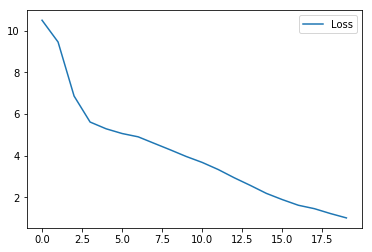

In [236]:
#rec_loss = np.load('./model/seq2seq/rec_loss1.npy')

import matplotlib.pyplot as plt

plt_loss = plt.plot([rec_loss[i] for i in range(len(rec_loss))])
plt.legend(['Loss'])
plt.show()

In [237]:
import nltk

def cherry_pick(records, n, upper_bound=1.0):
    bleus = []
    
    for en, ch_gr, ch_pd in records:
        # caculate BLEU by nltk
        bleu = nltk.translate.bleu_score.sentence_bleu([ch_gr], ch_pd)
        bleus.append(bleu)
    
    lst = [i for i in range(len(records)) if bleus[i]<=upper_bound]
    lst = sorted(lst, key=lambda i: bleus[i], reverse=True) # sort by BLEU score
    
    return [records[lst[i]] for i in range(n)]

### 找出符合5個問題的set儲存起來

In [240]:
import random as rd

records = []

for i in range(batch_num):
    print(i)
    #i = rd.randint(0, batch_num - 1)  # random pick one to translate
  
    x, y, g, w = batch.get(i)
    out = model.output(x, y)
    pd = model.predict(x, vob['<BEG>'])
    
    for j in range(256):
        #j = rd.randint(0, BATCH_SIZE - 1)
        en = [vob_rev[x[k][j]] for k in range(question_corpus_max)]
        en = en[:en.index('<PAD>')]
        if (['Hello.'] == en)|(['How','are','you?']== en)|(['Where','are','you','going?']== en)| (['You','look','great.'] == en)|(['Good','night.'] == en)  :
            print(en)
            ch_gr = [vob_rev[g[k][j]] for k in range(answer_corpus_max)]
            if '<END>' in ch_gr:
                ch_gr = ch_gr[:ch_gr.index('<END>')]
            ch_pd = [vob_rev[np.argmax(pd[i][j, :])] for i in range(answer_corpus_max)]
            if '<END>' in ch_pd:
                ch_pd = ch_pd[:ch_pd.index('<END>')]

            records.append([en, ch_gr, ch_pd])

0
['Hello.']
['Where', 'are', 'you', 'going?']
1
['Where', 'are', 'you', 'going?']
2
['You', 'look', 'great.']
['Good', 'night.']
['Good', 'night.']
['How', 'are', 'you?']


In [192]:
#測試
#len(batch.get(2))
#a1 = 0
#a2 = 2
#a3 = 21
#
#print(vob_rev[batch.get(a1)[0][a2][a3]]+' '+vob_rev[batch.get(a1)[0][a2+1][a3]]+' '+vob_rev[batch.get(a1)[0][a2+2][a3]]+' '+\
#vob_rev[batch.get(a1)[0][a2+3][a3]])
#
#print(vob_rev[batch.get(a1)[2][a2][a3]]+' '+vob_rev[batch.get(a1)[2][a2+1][a3]]+' '+vob_rev[batch.get(a1)[2][a2+2][a3]]+' '+\
#vob_rev[batch.get(a1)[2][a2+3][a3]])

Good boy. <PAD> <PAD>
Jack. <END> <PAD> <PAD>


In [241]:
print("Encoder input")
print("Ground truth")
print("Decoder output")
print()

n = len(records)  # how many result we show
rec_cherry = cherry_pick(records, n)

for i in range(n):
  for j in range(3):
    print(' '.join(rec_cherry[i][j]))

  print('')

Encoder input
Ground truth
Decoder output

Where are you going?
I'm just leaving.
I'm just leaving.

Where are you going?
I'm just leaving.
I'm just leaving.

How are you?
Another young man.
Another young man.

Good night.
Good night.
Good night.

Good night.
Good night.
Good night.

You look great.
Thanks.
Thanks.

Hello.
Nice to see you.
You crucifying you.



C:\Users\stat_pc\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\stat_pc\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\stat_pc\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  

# Report

1.首先先做資料清理，清洗完後按照之前第一次比賽的邏輯把資料count起來算idf。


2.由於有指定需要的5個問題，先在train的地方確保這些字有在裡面。


3.在seq2seq嘗試了許多次 發現epoch其實不用太高train在loss的反應上表現就不錯了


4.資料清洗的地方做得還不夠徹底，導致train太多資料時電腦當機了許多次。
